## Part A: Subreddit Prediction ##

In [1]:
subreddit_train = "coursework_subreddit_train.json"
subreddit_test = "coursework_subreddit_test.json"

#!gsutil cp gs://textasdata/coursework/coursework_subreddit_train.json $subreddit_train 
#!gsutil cp gs://textasdata/coursework/coursework_subreddit_test.json  $subreddit_test

In [2]:
import pandas as pd

train_threads = pd.read_json(path_or_buf=subreddit_train, lines=True)
print(list(train_threads.columns.values))
print(train_threads.head())
print(train_threads.size)

['is_self_post', 'posts', 'subreddit', 'title', 'url']
   is_self_post                                              posts  \
0           1.0  [{'body': 'I think everyone has that one frien...   
1           1.0  [{'body': 'I not 100% sure this is the right p...   
2           1.0  [{'body': '', 'author': 'Leisure321', 'url': '...   
3           1.0  [{'body': 'It's called 'forgetting things'.', ...   
4           1.0  [{'body': 'How would I do this? I am looking t...   

        subreddit                                              title  \
0   relationships  How do I [23F] communicate with my self-center...   
1  summonerschool  What Cherry switch do you recommend for League...   
2       askreddit                   Where do memes go when they die?   
3           trees                     Some weird long term affects??   
4        buildapc  Simple question: If I install Windows to a sta...   

                                                 url  
0  https://www.reddit.com/r/relation

In [3]:
test_threads = pd.read_json(path_or_buf=subreddit_test, lines=True)
print(test_threads.head())
print(test_threads.size)

   is_self_post                                              posts  \
0           1.0  [{'body': 'Was watching a VOD from last years ...   
1           1.0  [{'body': 'Basically what the title says.', 'u...   
2           1.0  [{'body': '', 'author': 'Daft-Punk', 'url': 'h...   
3           1.0  [{'body': 'I start running this year. I do it ...   
4           1.0  [{'body': '[deleted]', 'url': 'https://www.red...   

       subreddit                                              title  \
0      starcraft  Just a reminder on how much SC2 has evolved th...   
1    whowouldwin  Your Favorite Hero Now Has A Healing Factor As...   
2      askreddit  If you could live anywhere in the world, where...   
3      askreddit                   Do you ever get use to exercise?   
4  tipofmytongue         [TOMT] [book] A scary french book for kids   

                                                 url  
0  https://www.reddit.com/r/starcraft/comments/mq...  
1  https://www.reddit.com/r/whowouldwin/co

In [4]:
subreddit_counts = train_threads['subreddit'].value_counts()
print(subreddit_counts.describe())
top_subbreddits = subreddit_counts.nlargest(20)
top_subbreddits_list = top_subbreddits.index.tolist()
print(top_subbreddits)

count     20.000000
mean      72.800000
std       73.368285
min       28.000000
25%       36.250000
50%       45.500000
75%       63.750000
max      334.000000
Name: subreddit, dtype: float64
askreddit               334
leagueoflegends         196
buildapc                131
explainlikeimfive        82
trees                    66
techsupport              63
pcmasterrace             62
gaming                   62
electronic_cigarette     59
relationships            48
tipofmytongue            43
jailbreak                38
hearthstone              38
atheism                  37
summonerschool           37
reddit.com               34
whowouldwin              33
movies                   33
personalfinance          32
starcraft                28
Name: subreddit, dtype: int64


In [5]:
train_labels = train_threads['subreddit']
test_labels = test_threads['subreddit']

In [6]:
# Initialise nlp
import spacy
#!python -m spacy download en_core_web_md

nlp = spacy.load('/usr/lib/python3.7/site-packages/en_core_web_md/en_core_web_md-2.0.0', disable=['ner'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')

('parser', <spacy.pipeline.DependencyParser at 0x7f881071abf8>)

In [7]:
# Get Stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>


False

In [130]:
# Define tokenizer and normalizer

#@Tokenize
def spacy_tokenize(string):
    tokens = list()
    doc = nlp(string)
    for token in doc:
        tokens.append(token)
    return tokens

#@Normalize
def normalize(tokens):
    normalized_tokens = list()
    for token in tokens:
        normalized = token.text.lower().strip()
        if ((token.is_alpha or token.is_digit)):
          normalized_tokens.append(normalized)
    return normalized_tokens

#@Tokenize and normalize
def tokenize_normalize(string):
    return normalize(spacy_tokenize(string))

In [131]:
# Create vectorizers

from sklearn.feature_extraction.text import CountVectorizer 
def one_hot_vectorizer(**kwargs):
    return CountVectorizer(tokenizer=tokenize_normalize, binary=True, **kwargs)

from sklearn.feature_extraction.text import TfidfVectorizer
def tfidf_vectorizer(**kwargs):
    return TfidfVectorizer(tokenizer=tokenize_normalize, **kwargs)

In [132]:
# Create Classifiers

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

most_freq_class = DummyClassifier(strategy="most_frequent")
rand_class = DummyClassifier(strategy="stratified")
log_reg_class = LogisticRegression(solver="saga")
svc_class = SVC(kernel="rbf")
ber_nb_class = BernoulliNB() # Chosen classifier

In [133]:
def expand_posts(threads):
    """ Lines below explained in order:
    Split posts column into new columns
    Merge the back into train_threads
    Drop the unexpanded posts
    Transform the numeric rows from the split into separate rows
    Remove variable column left from melt
    Remove all rows with NaN
    """
    expanded_posts = threads.posts.apply(pd.Series)\
    .merge(threads.rename(columns={'url': 'thread_url'}), left_index=True, right_index=True)\
    .drop(["posts"], axis=1)\
    .melt(id_vars=["is_self_post", "subreddit", "title", "thread_url"], value_name="post")\
    .drop("variable", axis=1)\
    .dropna()

    # Expand the post dictionary into columns and remove invalid posts
    return pd.concat([
        expanded_posts.drop(['post'], axis=1),
        expanded_posts['post'].apply(pd.Series)
    ], axis=1)\
.dropna(subset=['body', 'author'])

In [134]:
# Restructure threads into posts
train_posts = expand_posts(train_threads)
test_posts = expand_posts(test_threads)

In [135]:
def expand_body_title(threads):
    return pd.concat([threads, threads.posts.apply(lambda posts: pd.Series(posts)\
                                             .map(lambda x: x['body'] if 'body' in x else '')\
                                             .str.cat(sep=' ')).rename(index='body'),\
                      threads.posts.apply(lambda posts: pd.Series(posts)\
                                             .map(lambda x: x['author'] if 'author' in x else '')\
                                             .str.cat(sep=' ')).rename(index='author')\
                     ],axis=1)

train_threads_expand = expand_body_title(train_threads)
test_threads_expand = expand_body_title(test_threads)

In [136]:
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.    """

    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]
    

In [148]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
import seaborn as sn
import matplotlib.pyplot as plt

def print_matrix(predictions, true_labels):
    print(classification_report(predictions, true_labels, digits=3))
    con_mat = confusion_matrix(true_labels, predictions)
    df_con_mat = pd.DataFrame(con_mat, index=sorted(list(set(true_labels))), columns=sorted(list(set(true_labels))))
    plt.figure()
    sn.heatmap(df_con_mat, cmap='PuRd', annot=True, fmt='g')
    plt.show()
    
def print_graph(predictions, true_labels):
    data = classification_report(predictions, true_labels, digits=3, output_dict=True)
    del data['micro avg']
    del data['macro avg']
    del data['weighted avg']
    data = {k:v['f1-score'] for k, v in data.items()}
    plt.figure()
    plt.bar(list(data.keys()), list(data.values()))
    plt.xticks(rotation='vertical')
    plt.xlabel('Subreddits')
    plt.ylabel('F1 Scores')
    plt.show()
    
def evaluation(predicts, true_labels):
    best_f1 = -1
    best_pred = None
    
    for (description, pred) in predicts.items():
        print("Evaluation for: " + description)
        precision = precision_score(pred, true_labels, average='macro')
        recall = recall_score(pred, true_labels, average='macro')
        accuracy = accuracy_score(pred, true_labels)
        f1 = fbeta_score(pred, true_labels, 1, average='macro') #1 means f_1 measure
        print("Classifier '%s' has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision,recall,f1))
        if f1 > best_f1:
            best_f1 = f1
            best_pred = pred
            
    print("Best Confusion Matrix"),
    print_matrix(best_pred, true_labels)
    print_graph(best_pred, true_labels)

In [138]:
from sklearn.pipeline import Pipeline, FeatureUnion 
one_hot_pipeline = Pipeline([
    ("union", FeatureUnion([
        ("title", Pipeline([
            ("select", ItemSelector('title')),
            ("vec", one_hot_vectorizer())
        ])),
        ("body", Pipeline([
            ("select", ItemSelector('body')),
            ("vec", one_hot_vectorizer())
        ])),
        ("author", Pipeline([
            ("select", ItemSelector('author')),
            ("vec", one_hot_vectorizer())
        ])),
    ]))
])
train_one_hot_features = one_hot_pipeline.fit_transform(train_threads_expand)
test_one_hot_features = one_hot_pipeline.transform(test_threads_expand)

In [139]:
tfidf_pipeline = Pipeline([
    ("union", FeatureUnion([
        ("title", Pipeline([
            ("select", ItemSelector('title')),
            ("vec", tfidf_vectorizer())
        ])),
        ("body", Pipeline([
            ("select", ItemSelector('body')),
            ("vec", tfidf_vectorizer())
        ])),
        ("author", Pipeline([
            ("select", ItemSelector('author')),
            ("vec", tfidf_vectorizer())
        ])),
    ]))
])
train_tfidf_features = tfidf_pipeline.fit_transform(train_threads_expand)
test_tfidf_features = tfidf_pipeline.transform(test_threads_expand)

/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Evaluation for: One-Hot Most Freq
Classifier 'One-Hot Most Freq' has Acc=0.230 P=0.050 R=0.012 F1=0.019
Evaluation for: One-Hot Random
Classifier 'One-Hot Random' has Acc=0.110 P=0.067 R=0.066 F1=0.065
Evaluation for: One-Hot Logistic Regression
Classifier 'One-Hot Logistic Regression' has Acc=0.690 P=0.585 R=0.723 F1=0.614
Evaluation for: One-Hot SVC
Classifier 'One-Hot SVC' has Acc=0.230 P=0.050 R=0.012 F1=0.019
Evaluation for: One-Hot BernoulliNB
Classifier 'One-Hot BernoulliNB' has Acc=0.304 P=0.085 R=0.069 F1=0.063
Best Confusion Matrix
                      precision    recall  f1-score   support

           askreddit      0.917     0.670     0.774       115
             atheism      0.500     0.857     0.632         7
            buildapc      0.784     0.806     0.795        36
electronic_cigarette      0.889     0.800     0.842        10
   explainlikeimfive      0.786     0.611     0.688        18
              gaming      0.412     0.389     0.400        18
         hearthst

/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


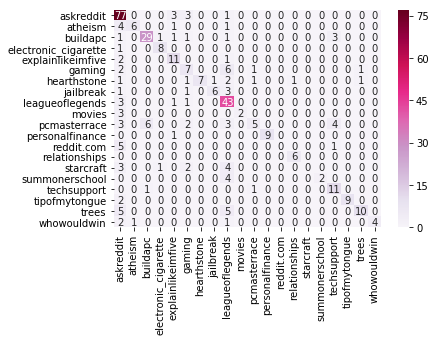

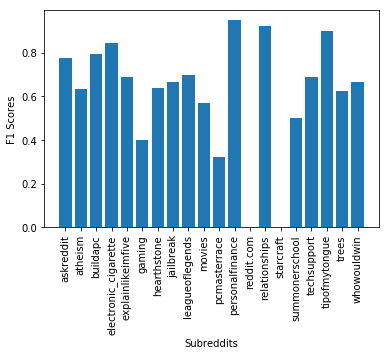

In [149]:
most_freq_class.fit(train_one_hot_features, train_threads_expand['subreddit'])
rand_class.fit(train_one_hot_features, train_threads_expand['subreddit'])
log_reg_class.fit(train_one_hot_features, train_threads_expand['subreddit'])
svc_class.fit(train_one_hot_features, train_threads_expand['subreddit'])
ber_nb_class.fit(train_one_hot_features, train_threads_expand['subreddit'])

predicts = {}
predicts['One-Hot Most Freq'] = most_freq_class.predict(test_one_hot_features)
predicts['One-Hot Random'] = rand_class.predict(test_one_hot_features)
predicts['One-Hot Logistic Regression'] = log_reg_class.predict(test_one_hot_features)
predicts['One-Hot SVC'] = svc_class.predict(test_one_hot_features)
predicts['One-Hot BernoulliNB'] = ber_nb_class.predict(test_one_hot_features)

evaluation(predicts, test_threads_expand['subreddit'])

/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Evaluation for: TF-IDF Most Freq
Classifier 'TF-IDF Most Freq' has Acc=0.230 P=0.050 R=0.012 F1=0.019
Evaluation for: TF-IDF Random
Classifier 'TF-IDF Random' has Acc=0.085 P=0.039 R=0.037 F1=0.037
Evaluation for: TF-IDF Logistic Regression
Classifier 'TF-IDF Logistic Regression' has Acc=0.575 P=0.389 R=0.658 F1=0.423
Evaluation for: TF-IDF SVC
Classifier 'TF-IDF SVC' has Acc=0.230 P=0.050 R=0.012 F1=0.019
Evaluation for: TF-IDF BernoulliNB
Classifier 'TF-IDF BernoulliNB' has Acc=0.304 P=0.085 R=0.069 F1=0.063
Best Confusion Matrix
                      precision    recall  f1-score   support

           askreddit      0.952     0.457     0.618       175
             atheism      0.083     1.000     0.154         1
            buildapc      0.838     0.816     0.827        38
electronic_cigarette      0.667     0.857     0.750         7
   explainlikeimfive      0.429     0.750     0.545         8
              gaming      0.118     0.400     0.182         5
         hearthstone      0

/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


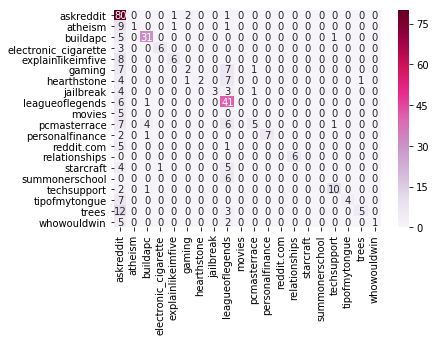

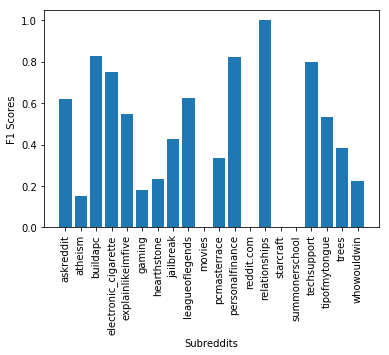

In [150]:
most_freq_class.fit(train_tfidf_features, train_threads_expand['subreddit'])
rand_class.fit(train_tfidf_features, train_threads_expand['subreddit'])
log_reg_class.fit(train_tfidf_features, train_threads_expand['subreddit'])
svc_class.fit(train_tfidf_features, train_threads_expand['subreddit'])
ber_nb_class.fit(train_tfidf_features, train_threads_expand['subreddit'])

predicts = {}
predicts['TF-IDF Most Freq'] = most_freq_class.predict(test_tfidf_features)
predicts['TF-IDF Random'] = rand_class.predict(test_tfidf_features)
predicts['TF-IDF Logistic Regression'] = log_reg_class.predict(test_tfidf_features)
predicts['TF-IDF SVC'] = svc_class.predict(test_tfidf_features)
predicts['TF-IDF BernoulliNB'] = ber_nb_class.predict(test_tfidf_features)

evaluation(predicts, test_threads_expand['subreddit'])

In [158]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer
from scipy import stats

cv_pipeline = Pipeline([
    ('tfidf', tfidf_pipeline),
    ('class', LogisticRegression(solver="saga"))
])
ngram_ranges = [(y, x) for x in range(4) for y in range(x)]
tfidf_params = {
    'tfidf__union__title__vec__sublinear_tf': stats.randint(0, 1),
    'tfidf__union__title__vec__ngram_range': ngram_ranges,
    'tfidf__union__title__vec__max_features': stats.randint(0, 50000),
    'tfidf__union__body__vec__sublinear_tf': stats.randint(0, 1),
    'tfidf__union__body__vec__ngram_range': ngram_ranges,
    'tfidf__union__body__vec__max_features': stats.randint(0, 50000),
    'tfidf__union__author__vec__sublinear_tf': stats.randint(0, 1),
    'tfidf__union__author__vec__ngram_range': ngram_ranges,
    'tfidf__union__author__vec__max_features': stats.randint(0, 50000),
    'class__C': np.logspace(-3, 4, num=7),
    'class__solver': ['saga', 'sag', 'newton-cg', 'lbjgs'],
    'class__multi_class': ['ovr', 'auto', 'multinominal']
}

cv_tfidf = RandomizedSearchCV(cv_pipeline, tfidf_params, n_jobs=1, scoring=make_scorer(f1_score, average='macro'), cv=2)
cv_tfidf.fit(train_threads_expand, train_threads_expand['subreddit'])
test_threads_cv_features = cv_tfidf.transform(test_threads_expand)
evaluation({'CV TF-IDF Log-Reg', log_reg_class.predict(test_threads_cv_features)}, test_threads_expand['subreddit'])

KeyboardInterrupt: 

## Part B: Discourse prediction ##

In [10]:
discourse_train = "coursework_discourse_train.json"
discourse_test = "coursework_discourse_test.json"
  
#!gsutil cp gs://textasdata/coursework/coursework_discourse_train.json $discourse_train  
#!gsutil cp gs://textasdata/coursework/coursework_discourse_test.json  $discourse_test

In [115]:
# The reddit thread structure is nested with posts in a new content.
# This block reads the file as json and creates a new data frame.
import pandas as pd
import json


def load_posts(file):
    # A temporary variable to store the list of post content.
    posts_tmp = list()

    with open(file) as jsonfile:
        for i, line in enumerate(jsonfile):
            # if (i > 2): break
            thread = json.loads(line)
            inital_author = ""
            for post in thread['posts']:
                if post.get('post_depth', 0) == 0:
                    inital_author = post.get('author', '')
                    break
            for post in thread['posts']:
                # NOTE: This could be changed to use additional features from the post or thread.
                # DO NOT change the labels for the test set.
                posts_tmp.append((thread['subreddit'], thread['title'], thread['url'],
                                  post['id'], post.get('author', ""), post.get('body', ""),
                                  post.get("majority_link", ""),
                                  post.get('post_depth', 0), post.get('majority_type', ""),  # discourse type label 
                                  post.get('in_reply_to', ""), thread['is_self_post'],
                                  post.get('author', "") == inital_author))

    # Create the posts data frame.  
    labels = ['subreddit', 'title', 'url', 'id', 'author', 'body', 'majority_link',
              'post_depth', 'discourse_type', 'in_reply_to', 'is_self_post', 'is_initial_author']
    return pd.DataFrame(posts_tmp, columns=labels)


In [116]:
train_posts = load_posts(discourse_train)
# Filter out empty labels
train_posts = train_posts[train_posts['discourse_type'] != ""]#[:7000]
print(train_posts.head())
print("Num posts: ", train_posts.size)

    subreddit                           title  \
0  worldofpvp  Help me decide my new PvP main   
1  worldofpvp  Help me decide my new PvP main   
2  worldofpvp  Help me decide my new PvP main   
3  worldofpvp  Help me decide my new PvP main   
4  worldofpvp  Help me decide my new PvP main   

                                                 url          id  \
0  https://www.reddit.com/r/worldofpvp/comments/2...   t3_2v0anq   
1  https://www.reddit.com/r/worldofpvp/comments/2...  t1_codb2p9   
2  https://www.reddit.com/r/worldofpvp/comments/2...  t1_codg0we   
3  https://www.reddit.com/r/worldofpvp/comments/2...  t1_coeatsq   
4  https://www.reddit.com/r/worldofpvp/comments/2...  t1_codbyit   

         author                                               body  \
0      TyrickEU  Hi. \nAs a raider previously, i had no problem...   
1          vurt  [deleted]  \n ^^^^^^^^^^^^^^^^0.5422 \n > [Wha...   
2   OptimusNice  This goes mostly for 3v3 since that seems to b...   
3               

The label for the post we will be predicting is in the discourse_type column.

In [117]:
test_posts = load_posts(discourse_test)
# Filter out empty labels
test_posts = test_posts[test_posts['discourse_type'] != ""]
print("Num posts: ", test_posts.size)


Num posts:  237744


In [118]:
train_labels = train_posts['discourse_type']
test_labels = test_posts['discourse_type']

Examine the distribution over labels on the training data.

In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
log_class = LogisticRegression(solver='saga')
discorse_pipeline = Pipeline([
    ('union', FeatureUnion([
        ('body', Pipeline([
            ('select', ItemSelector('body')),
            ('vec', tfidf_vectorizer())
        ])),
        ('title', Pipeline([
            ('select', ItemSelector('title')),
            ('vec', tfidf_vectorizer())
        ])),
        ('author', Pipeline([
            ('select', ItemSelector('author')),
            ('vec', tfidf_vectorizer())
        ])),
    ]))
])

discorse_pipeline.fit(train_posts, train_labels)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=None,
       transformer_list=[('body', Pipeline(memory=None,
     steps=[('select', ItemSelector(key='body')), ('vec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=...kenizer=<function tokenize_normalize at 0x7f87cb20b598>,
        use_idf=True, vocabulary=None))]))],
       transformer_weights=None))])

In [120]:
discourse_counts = train_labels.value_counts()
print(discourse_counts.describe())

top_discourse = discourse_counts.nlargest(200)
print(top_discourse)
top_discourse = top_discourse.index.tolist()
print(top_discourse)

count       10.000000
mean      7926.700000
std       9664.321866
min       1266.000000
25%       1671.500000
50%       3235.500000
75%      11919.750000
max      31419.000000
Name: discourse_type, dtype: float64
answer              31419
elaboration         14775
question            13610
appreciation         6849
agreement            3868
disagreement         2603
humor                1787
other                1633
announcement         1457
negativereaction     1266
Name: discourse_type, dtype: int64
['answer', 'elaboration', 'question', 'appreciation', 'agreement', 'disagreement', 'humor', 'other', 'announcement', 'negativereaction']


In [121]:
# Define the features
X_train = discorse_pipeline.transform(train_posts)
X_test = discorse_pipeline.transform(test_posts)

from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy='stratified',random_state=0)
clf.fit(X_train, train_posts['discourse_type'])
predictions = clf.predict(X_test)  
print(classification_report(predictions, test_posts['discourse_type']))

                  precision    recall  f1-score   support

       agreement       0.05      0.06      0.06       934
    announcement       0.02      0.02      0.02       382
          answer       0.39      0.39      0.39      7910
    appreciation       0.08      0.08      0.08      1603
    disagreement       0.04      0.03      0.04       686
     elaboration       0.19      0.18      0.19      3711
           humor       0.02      0.02      0.02       449
negativereaction       0.03      0.03      0.03       297
           other       0.02      0.02      0.02       395
        question       0.17      0.17      0.17      3445

       micro avg       0.23      0.23      0.23     19812
       macro avg       0.10      0.10      0.10     19812
    weighted avg       0.23      0.23      0.23     19812



Evaluation for: Log Reg TF-IDF
Classifier 'Log Reg TF-IDF' has Acc=0.508 P=0.236 R=0.481 F1=0.250
Best Confusion Matrix
                  precision    recall  f1-score   support

       agreement      0.182     0.542     0.272       319
    announcement      0.008     0.750     0.016         4
          answer      0.830     0.509     0.631     12958
    appreciation      0.590     0.764     0.666      1327
    disagreement      0.016     0.270     0.029        37
     elaboration      0.180     0.301     0.225      2164
           humor      0.009     0.308     0.017        13
negativereaction      0.023     0.368     0.043        19
           other      0.056     0.457     0.100        46
        question      0.464     0.543     0.500      2925

       micro avg      0.508     0.508     0.508     19812
       macro avg      0.236     0.481     0.250     19812
    weighted avg      0.674     0.508     0.560     19812



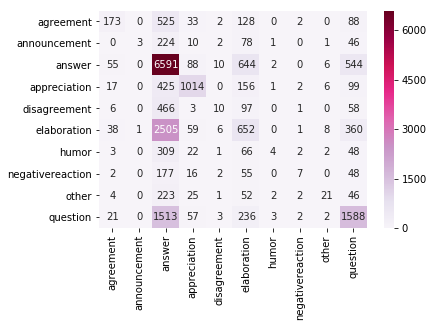

In [122]:
log_class.fit(X_train, train_labels)
evaluation({'Log Reg TF-IDF': log_class.predict(X_test)}, test_labels)

In [123]:
class ExistSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data):
        return data.apply(lambda x: self.key in x)
    

In [124]:
import numpy as np

def reshape(x):
    return x.values.reshape(-1,1)

def nan_handle(x):
    return np.nan_to_num(x)

In [125]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer

full_discorse_pipeline = Pipeline([
    ('union', FeatureUnion([
         ('subreddit', Pipeline([
             ('select', ItemSelector('subreddit')),
             ('vec', tfidf_vectorizer())
         ])),
         ('self', Pipeline([
             ('exist', ItemSelector('is_self_post')),
             ('reshape', FunctionTransformer(reshape, validate=False)),
             ('nan', FunctionTransformer(nan_handle, validate=False))
         ])),
         ('depth', Pipeline([
             ('select', ItemSelector('post_depth')),
             ('reshape', FunctionTransformer(reshape, validate=False))
         ])),
        ('body_(uni,bi,tri)grams', Pipeline([
            ('select', ItemSelector('body')),
            ('vec', tfidf_vectorizer(ngram_range=(1,3)))
        ])),
        ('subreddit_body', Pipeline([
            ('union', FeatureUnion([
                ('subreddit', Pipeline([
                    ('select', ItemSelector('subreddit')),
                    ('vec', tfidf_vectorizer())
                ])),
                ('body', Pipeline([
                    ('select', ItemSelector('body')),
                    ('vec', tfidf_vectorizer())
                ])),
            ]))
        ])),
        ('inital', Pipeline([
            ('select', ItemSelector('is_initial_author')),
            ('reshape', FunctionTransformer(reshape, validate=False))
        ])),
    ]))
])

Evaluation for: Pipeline
Classifier 'Pipeline' has Acc=0.590 P=0.330 R=0.505 F1=0.356
Best Confusion Matrix
                  precision    recall  f1-score   support

       agreement      0.216     0.553     0.310       371
    announcement      0.460     0.691     0.553       243
          answer      0.849     0.603     0.705     11184
    appreciation      0.625     0.772     0.691      1392
    disagreement      0.037     0.369     0.068        65
     elaboration      0.318     0.405     0.356      2854
           humor      0.035     0.271     0.062        59
negativereaction      0.046     0.311     0.080        45
           other      0.048     0.439     0.086        41
        question      0.664     0.639     0.651      3558

       micro avg      0.590     0.590     0.590     19812
       macro avg      0.330     0.505     0.356     19812
    weighted avg      0.698     0.590     0.628     19812



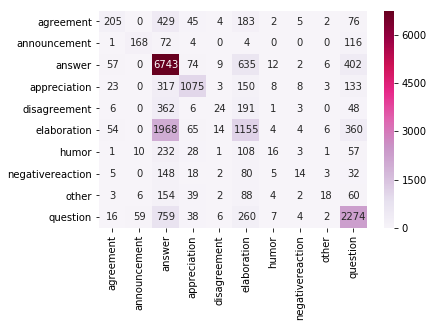

In [126]:
full_discorse_pipeline.fit(train_posts, train_labels)
train_features = full_discorse_pipeline.transform(train_posts)
test_features = full_discorse_pipeline.transform(test_posts)

log_class.fit(train_features, train_labels)
evaluation({'Pipeline': log_class.predict(test_features)}, test_labels)

In [ ]:
0.270